In [ ]:
!pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.5 MB/s eta 0:00:00


In [ ]:
import torch
import monai
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from monai.networks.nets import unet
from monai.networks.blocks import Warp, DVF2DDF
from monai.config import USE_COMPILED
from tqdm import tqdm
from torch.nn import MSELoss
import numpy as np

In [ ]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from typing import Union

import torch
from torch.nn.modules.loss import _Loss

from monai.utils import LossReduction


def spatial_gradient(x: torch.Tensor, dim: int) -> torch.Tensor:
    """
    Calculate gradients on single dimension of a tensor using central finite difference.
    It moves the tensor along the dimension to calculate the approximate gradient
    dx[i] = (x[i+1] - x[i-1]) / 2.
    Adapted from:
        DeepReg (https://github.com/DeepRegNet/DeepReg)

    Args:
        x: the shape should be BCH(WD).
        dim: dimension to calculate gradient along.
    Returns:
        gradient_dx: the shape should be BCH(WD)
    """
    slice_1 = slice(1, -1)
    slice_2_s = slice(2, None)
    slice_2_e = slice(None, -2)
    slice_all = slice(None)
    slicing_s, slicing_e = [slice_all, slice_all], [slice_all, slice_all]
    while len(slicing_s) < x.ndim:
        slicing_s = slicing_s + [slice_1]
        slicing_e = slicing_e + [slice_1]
    slicing_s[dim] = slice_2_s
    slicing_e[dim] = slice_1 #slice_2_e
    return (x[slicing_s] - x[slicing_e])# / 2.0


class GradEnergyLoss(_Loss):
    """
    Calculate the Grad energy based on first-order differentiation of pred using forward finite difference.

    Adapted from:
        DeepReg (https://github.com/DeepRegNet/DeepReg)
    """

    def __init__(self, normalize: bool = False, reduction: Union[LossReduction, str] = LossReduction.MEAN) -> None:
        """
        Args:
            normalize:
                Whether to divide out spatial sizes in order to make the computation roughly
                invariant to image scale (i.e. vector field sampling resolution). Defaults to False.
            reduction: {``"none"``, ``"mean"``, ``"sum"``}
                Specifies the reduction to apply to the output. Defaults to ``"mean"``.

                - ``"none"``: no reduction will be applied.
                - ``"mean"``: the sum of the output will be divided by the number of elements in the output.
                - ``"sum"``: the output will be summed.
        """
        super().__init__(reduction=LossReduction(reduction).value)
        self.normalize = normalize

    def forward(self, pred: torch.Tensor) -> torch.Tensor:
        """
        Args:
            pred: the shape should be BCH(WD)

        Raises:
            ValueError: When ``self.reduction`` is not one of ["mean", "sum", "none"].

        """
        if pred.ndim not in [3, 4, 5]:
            raise ValueError(f"Expecting 3-d, 4-d or 5-d pred, instead got pred of shape {pred.shape}")
        for i in range(pred.ndim - 2):
            if pred.shape[-i - 1] <= 4:
                raise ValueError(f"All spatial dimensions must be > 4, got spatial dimensions {pred.shape[2:]}")
        if pred.shape[1] != pred.ndim - 2:
            raise ValueError(
                f"Number of vector components, {pred.shape[1]}, does not match number of spatial dimensions, {pred.ndim-2}"
            )

        # first order gradient
        first_order_gradient = [spatial_gradient(pred, dim) for dim in range(2, pred.ndim)]

        # spatial dimensions in a shape suited for broadcasting below
        if self.normalize:
            spatial_dims = torch.tensor(pred.shape, device=pred.device)[2:].reshape((1, -1) + (pred.ndim - 2) * (1,))

        energy = 0

        for dim in range(len(first_order_gradient)):
          energy += first_order_gradient[dim] ** 2

        if self.reduction == LossReduction.MEAN.value:
            energy = torch.mean(energy)  # the batch and channel average
        elif self.reduction == LossReduction.SUM.value:
            energy = torch.sum(energy)  # sum over the batch and channel dims
        elif self.reduction != LossReduction.NONE.value:
            raise ValueError(f'Unsupported reduction: {self.reduction}, available options are ["mean", "sum", "none"].')

        return energy


In [ ]:
from tensorflow.keras.datasets import mnist


(x_train_load, y_train_load), (x_test_load, y_test_load) = mnist.load_data()


digit_sel1 = 0
digit_sel2 = 1

# extract instances of the first digit
x_train_digit1 = x_train_load[y_train_load == digit_sel1, ...]
y_train_digit1 = y_train_load[y_train_load == digit_sel1]
x_test_digit1 = x_test_load[y_test_load == digit_sel1, ...]
y_test_digit1 = y_test_load[y_test_load == digit_sel1]

# extract instances of the second digit
x_train_digit2 = x_train_load[y_train_load == digit_sel2, ...]
y_train_digit2 = y_train_load[y_train_load == digit_sel2]
x_test_digit2 = x_test_load[y_test_load == digit_sel2, ...]
y_test_digit2 = y_test_load[y_test_load == digit_sel2]

# concatenate the instances and labels of both digits
x_train = np.concatenate((x_train_digit1, x_train_digit2), axis=0)
y_train = np.concatenate((y_train_digit1, y_train_digit2), axis=0)
x_test = np.concatenate((x_test_digit1, x_test_digit2), axis=0)
y_test = np.concatenate((y_test_digit1, y_test_digit2), axis=0)

# shuffle the combined instances and labels
combined_data = list(zip(x_train, y_train))
np.random.shuffle(combined_data)
x_train, y_train = zip(*combined_data)

x_train= np.array(x_train)
y_train= np.array(y_train)

# let's get some shapes to understand what we loaded.
print('shape of x_train: {}, y_train: {}'.format(x_train.shape, y_train.shape))

fixed = np.float32(x_train[:200])
#fixed=fixed[None,:,:]
moving = np.float32(0*x_train[4])

fixed = resize(fixed,(fixed.shape[0],28,28))

NUM_PROTO = 2
moving = np.zeros((NUM_PROTO,28,28))
#0*resize(moving,(64,64))   #initialising the moving image to 0


11490434/11490434 [==============================] - 2s 0us/step
shape of x_train: (12665, 28, 28), y_train: (12665,)


In [ ]:
def img_is_color(img):

    if len(img.shape) == 3:
        # Check the color channels to see if they're all the same.
        c1, c2, c3 = img[:, : , 0], img[:, :, 1], img[:, :, 2]
        if (c1 == c2).all() and (c2 == c3).all():
            return True

    return False

def show_image_list(list_images, list_titles=None, list_cmaps=None, grid=True, num_cols=2, figsize=(20, 10), title_fontsize=30):
    '''
    Shows a grid of images, where each image is a Numpy array. The images can be either
    RGB or grayscale.

    Parameters:
    ----------
    images: list
        List of the images to be displayed.
    list_titles: list or None
        Optional list of titles to be shown for each image.
    list_cmaps: list or None
        Optional list of cmap values for each image. If None, then cmap will be
        automatically inferred.
    grid: boolean
        If True, show a grid over each image
    num_cols: int
        Number of columns to show.
    figsize: tuple of width, height
        Value to be passed to pyplot.figure()
    title_fontsize: int
        Value to be passed to set_title().
    '''

    assert isinstance(list_images, list)
    assert len(list_images) > 0
    assert isinstance(list_images[0], np.ndarray)

    if list_titles is not None:
        assert isinstance(list_titles, list)
        assert len(list_images) == len(list_titles), '%d imgs != %d titles' % (len(list_images), len(list_titles))

    if list_cmaps is not None:
        assert isinstance(list_cmaps, list)
        assert len(list_images) == len(list_cmaps), '%d imgs != %d cmaps' % (len(list_images), len(list_cmaps))

    num_images  = len(list_images)
    num_cols    = min(num_images, num_cols)
    num_rows    = int(num_images / num_cols) + (1 if num_images % num_cols != 0 else 0)

    # Create a grid of subplots.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]

    for i in range(num_images):

        img    = list_images[i]
        title  = list_titles[i] if list_titles is not None else 'Image %d' % (i)
        #cmap   = list_cmaps[i] if list_cmaps is not None else (None if img_is_color(img) else 'gray')

        im=list_axes[i].imshow(img, cmap='viridis', vmin=0, vmax=255)

        plt.colorbar(im,fraction=0.046, pad=0.04)
        list_axes[i].set_title(title, fontsize=title_fontsize)
        list_axes[i].grid(grid)

    for i in range(num_images, len(list_axes)):
        list_axes[i].set_visible(False)


    fig.tight_layout()
    _ = plt.show()


In [ ]:
nofixed=5
list_images=[moving]
name=['Fixed Image']
list_titles=list(np.repeat(name,nofixed))

for i in range(nofixed):
  list_images.append(fixed[i])

#show_image_list(list_images=list_images,
#                list_titles=['Moving Image']+list_titles,
#                num_cols=2,
#                figsize=(10, 10),
#                grid=False,
#                title_fontsize=15)

Text(0.5, 1.0, 'Average Image')

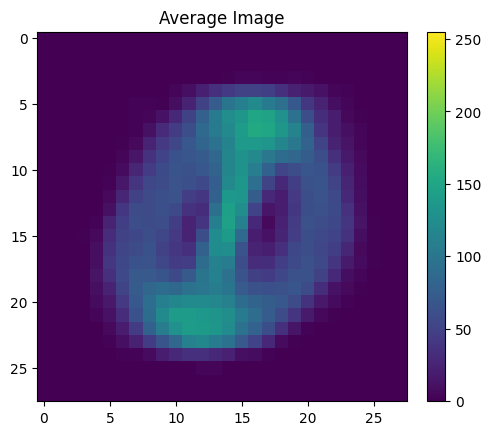

In [ ]:
sum=0
for i in range(100):
  sum+=fixed[i]

avg_fixed=sum/100
plt.imshow(avg_fixed,vmin=0, vmax=255)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Average Image')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x)

In [ ]:
'''
class Net(nn.Module):

    def __init__(self, num_classes=NUM_PROTO):
        super(Net,self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3,stride=1, padding=1)
        self.relu1 = nn.ReLU()

        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        self.lf = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)

    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)

        output = self.maxpool1(output)

        output = self.conv2(output)
        output = self.relu2(output)

        output = output.view(-1, 32 * 32 * 24)

        output = self.lf(output)

        return output'''

'\nclass Net(nn.Module):\n\n    def __init__(self, num_classes=NUM_PROTO):\n        super(Net,self).__init__()\n\n        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3,stride=1, padding=1)\n        self.relu1 = nn.ReLU()\n\n        self.maxpool1 = nn.MaxPool2d(kernel_size=2)\n\n        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)\n        self.relu2 = nn.ReLU()\n\n        self.lf = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)\n\n    def forward(self, input):\n        output = self.conv1(input)\n        output = self.relu1(output)\n\n        output = self.maxpool1(output)\n\n        output = self.conv2(output)\n        output = self.relu2(output)\n\n        output = output.view(-1, 32 * 32 * 24)\n\n        output = self.lf(output)\n\n        return output'

In [ ]:
prototype_selection_net = Net().to('cuda')
prototype_selection_net.train()

def select_prototype(image):

    #image = torch.from_numpy(image)

    # Predict the digit using the MNIST model
    #with torch.no_grad():
    prediction = prototype_selection_net(image)
    predicted_digit = torch.argmax(prediction,dim=1)

    return predicted_digit, prediction

In [ ]:
digit_sel = 1
x_train = x_train_load[y_train_load == digit_sel, ...]
x_train = np.float32(x_train)
x_train = x_train[:10,None,:,:]


from skimage.transform import resize

image = resize(x_train, (x_train.shape[0],1,28, 28))

print(image.shape)
#image = np.float32(x_train)

# Classify the image using the MNIST model
predicted_digit,prediction = select_prototype(torch.from_numpy(image).to('cuda'))

print(f"The image represents the digit: {predicted_digit}")


(10, 1, 28, 28)
The image represents the digit: tensor([0, 2, 4, 4, 4, 4, 3, 2, 4, 2], device='cuda:0')


<ipython-input-9-18859b8ec630>:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


In [ ]:
print(image.shape)
print(prediction.shape)
predicted_digit

(10, 1, 28, 28)
torch.Size([10, 10])


tensor([0, 2, 4, 4, 4, 4, 3, 2, 4, 2], device='cuda:0')

In [ ]:
reg = unet.UNet(spatial_dims=2,  # spatial dims
    in_channels=2,
    out_channels=2,# output channels (to represent 2D displacement vector field)
    channels=(16, 32, 32, 32, 32),  # channel sequence
    strides=(1, 2, 2, 4),  # convolutional strides
    dropout=0.2,
    norm="batch").to('cuda')

if USE_COMPILED:
    warp_layer = Warp(2, padding_mode="zeros").to('cuda')
else:
    warp_layer = Warp("bilinear", padding_mode="zeros").to('cuda')

dvf_2_ddf = DVF2DDF()

reg.train()

import torch.nn as nn

class Model(nn.Module):
    def __init__(self, img):
        super(Model, self).__init__()
        self.moving_img = nn.Parameter(img)

    def forward(self):
        return self.moving_img


moving_net = Model(torch.tensor(0*moving)).to('cuda')

optimizerR = torch.optim.Adam(reg.parameters(), lr=0.01)
optimizerM = torch.optim.Adam(moving_net.parameters(), lr=0.1)
optimizerP = torch.optim.Adam(prototype_selection_net.parameters(), lr=0.1)

moving_net.train()

/usr/local/lib/python3.10/dist-packages/monai/networks/blocks/warp.py:67: UserWarning: monai.networks.blocks.Warp: Using PyTorch native grid_sample.
  warnings.warn("monai.networks.blocks.Warp: Using PyTorch native grid_sample.")


Model()

In [ ]:
image_loss = MSELoss()
regularization_loss = GradEnergyLoss()
image_loss.to('cuda')

MSELoss()

In [ ]:
print(moving.shape)
print(fixed.shape)
fixedo = fixed
movingo=moving

(2, 28, 28)
(200, 28, 28)


In [ ]:
moving = moving_net()

print(moving.shape)


#print(torch.tile(moving[None,:,:,:],(fixed.shape[0],1,1,1)).shape)


torch.Size([2, 28, 28])


In [ ]:
fixed = fixedo[:,None,:,:]
#moving = np.tile(movingo,(fixed.shape[0],1,1,1))

max_epochs = 50000

loss_array=[]
epoch_array=[]

fixed = torch.tensor(fixed).to('cuda')

for epoch in tqdm(range(max_epochs)):

    optimizerM.zero_grad()
   # optimizerR.zero_grad()
    optimizerP.zero_grad()

    prototype_num, _ = select_prototype(fixed)



    moving1 = moving_net()
    moving = moving1[prototype_num,:,:]


    #moving = torch.tile(moving1[None,None,:,:],(fixed.shape[0],1,1,1))
    moving = moving.float()

    #input_data = torch.cat((moving[:,None,:,:], fixed), dim=1)
    #dvf = reg(input_data)
    #ddf = dvf_2_ddf(dvf)
    moved = moving[:,None,:,:] #warp_layer(moving[:,None,:,:], ddf)

    imgloss = image_loss(moved, fixed)# + 300000*regularization_loss(ddf)

    imgloss.backward()

    optimizerP.step()
    #optimizerR.step()
    optimizerM.step()

    loss_value=imgloss.item()
    loss_array.append(loss_value)
    epoch_array.append(epoch)
    #print(f"Epoch: {epoch}, Loss: {loss_value}")





  0%|          | 0/50000 [00:00<?, ?it/s]<ipython-input-9-18859b8ec630>:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)
  0%|          | 0/50000 [00:00<?, ?it/s]


RuntimeError: ignored

In [ ]:
moving1 = moving_net()
moving1=moving1.detach().to('cpu').numpy()
plt.imshow(moving1[0],vmin=0, vmax=200)

In [ ]:
plt.imshow(moving1[1],vmin=0, vmax=200)

In [ ]:
plt.imshow(moving1[2],vmin=0, vmax=200)

In [ ]:
output_images= [moving.detach()[0,0].to('cpu').numpy(),
               fixed[0,0].to('cpu').numpy(),
               moved[0,0].detach().to('cpu').numpy(),
               ddf[0,0].detach().to('cpu').numpy(),
               ddf[0,1].detach().to('cpu').numpy()]
show_image_list(list_images=output_images,
                list_titles=['Learnt Moving Image','Fixed Image','Moved Image','Deformation Field','Deformation Field'],
                num_cols=3,
                figsize=(10, 10),
                grid=False,
                title_fontsize=15)